# Stroke Prediction
This project analyzes a healthcare stroke dataset, performs data cleaning, feature engineering, and builds machine learning models (Logistic Regression, Random Forest) to predict stroke occurrence.
### Step 0: Load Libraries
This initial step imports all the essential Python libraries required for the project. These include libraries for data manipulation (pandas, numpy), data visualization (matplotlib, seaborn), and a comprehensive suite of tools from scikit-learn and tensorflow for data preprocessing, clustering, association rule mining, and building predictive models. 

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.cluster import KMeans
from mlxtend.frequent_patterns import apriori, association_rules
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping


from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, auc, accuracy_score, precision_score, recall_score, f1_score


warnings.filterwarnings("ignore")
pd.set_option("display.max_columns", None)
SEED = 42


### Step 1: Data Loading & Preprocessing
In this stage, the stroke dataset is loaded from an Excel file into a pandas DataFrame. Immediate preprocessing steps are performed to clean the data and prepare it for analysis. This includes removing irrelevant columns (id), handling rare categorical values ('Other' in gender), and imputing missing values in the bmi and smoking_status columns using logical and statistical methods to ensure data integrity.

In [35]:

# --- Load Data ---
df = pd.read_excel("stroke_data.xlsx")

# --- Initial Cleaning ---
# Remove the irrelevant 'id' column and the 'Other' gender category
if 'id' in df.columns:
    df = df.drop(columns=["id"])
df = df[df['gender'] != 'Other']

# --- Impute missing BMI values ---
# Create lookup tables for mean BMI by gender-age and by gender only
bmi_by_gender_age = df.groupby(['gender', 'age'])['bmi'].mean()
bmi_by_gender = df.groupby('gender')['bmi'].mean()

# Define a function for smart BMI imputation
def smart_bmi_filler(row):
    if pd.isna(row['bmi']):
        val = bmi_by_gender_age.get((row['gender'], row['age']))
        if pd.isna(val):
            val = bmi_by_gender[row['gender']] # Fallback to gender-only mean
        return val
    return row['bmi']

# Apply the imputation function
df['bmi'] = df.apply(smart_bmi_filler, axis=1)

# --- Handle 'Unknown' smoking_status values ---
# Logically assume children under 13 have never smoked
df.loc[(df['age'] < 13) & (df['smoking_status'] == 'Unknown'), 'smoking_status'] = 'never smoked'

# For the rest, fill 'Unknown' based on the distribution of known values
valid_smokers = df[df['smoking_status'] != 'Unknown']
probs = valid_smokers['smoking_status'].value_counts(normalize=True)
mask_unknown = df['smoking_status'] == 'Unknown'
random_smokers = np.random.choice(probs.index, size=mask_unknown.sum(), p=probs.values)
df.loc[mask_unknown, 'smoking_status'] = random_smokers

print("Missing values check after cleaning:")
print(df.isnull().sum())

print("\nPreview of the cleaned data:")
print(df.head())


Missing values check after cleaning:
gender               0
age                  0
hypertension         0
heart_disease        0
ever_married         0
work_type            0
Residence_type       0
avg_glucose_level    0
bmi                  0
smoking_status       0
stroke               0
dtype: int64

Preview of the cleaned data:
   gender   age  hypertension  heart_disease ever_married      work_type  \
0    Male  67.0             0              1          Yes        Private   
1  Female  61.0             0              0          Yes  Self-employed   
2    Male  80.0             0              1          Yes        Private   
3  Female  49.0             0              0          Yes        Private   
4  Female  79.0             1              0          Yes  Self-employed   

  Residence_type  avg_glucose_level        bmi   smoking_status  stroke  
0          Urban             228.69  36.600000  formerly smoked       1  
1          Rural             202.21  29.879487     never smoke

### Step 2: Unsupervised Learning - K-Means Clustering Analysis
The first analytical phase uses unsupervised learning to identify natural groupings or "profiles" of patients within the dataset without using the stroke outcome. The K-Means algorithm is applied to partition the data into clusters. First, the Elbow Method is used to determine the optimal number of clusters (k=3) by minimizing inertia (SSE). The final model is then trained, and the characteristics of each cluster are analyzed to understand their distinct demographic and clinical features.

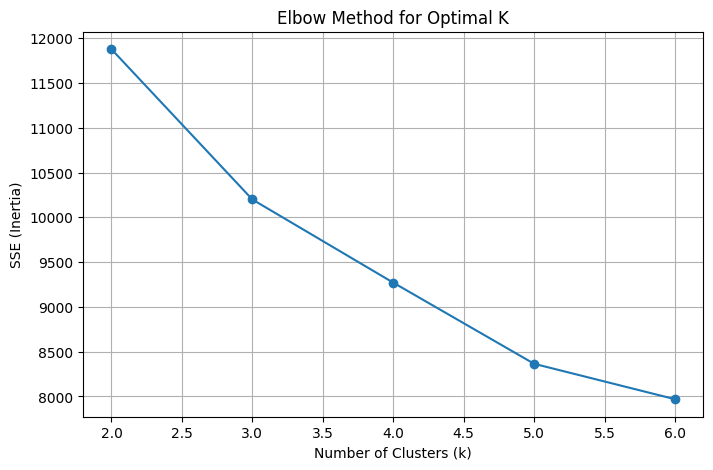


Distribution of records across clusters:
cluster
1    1756
2    1711
0    1642
Name: count, dtype: int64

Cluster characteristics (mean values):
               age  hypertension  heart_disease  avg_glucose_level        bmi  \
cluster                                                                         
0        54.236906      0.139464       0.073691         110.852180  30.828757   
1        22.011959      0.030182       0.018223          96.421452  25.261222   
2        54.443016      0.126242       0.071888         111.593191  30.850673   

           stroke  
cluster            
0        0.064555  
1        0.016515  
2        0.066628  


In [36]:
# --- Prepare data for clustering ---
df_cluster = df.copy()

# One-Hot Encode categorical variables
categorical_cols = ['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']
df_cluster_encoded = pd.get_dummies(df_cluster, columns=categorical_cols)

# Normalize numerical variables
numerical_cols = ['age', 'avg_glucose_level', 'bmi', 'hypertension', 'heart_disease']
scaler = MinMaxScaler()
df_cluster_encoded[numerical_cols] = scaler.fit_transform(df_cluster_encoded[numerical_cols])

# Exclude the target variable for clustering
X_cluster = df_cluster_encoded.drop(columns=['stroke'])

# --- Use the Elbow Method to find the optimal K ---
sse = []
K_range = range(2, 7)
for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=SEED, n_init=10)
    kmeans.fit(X_cluster)
    sse.append(kmeans.inertia_) # SSE is stored in the 'inertia_' attribute

plt.figure(figsize=(8, 5))
plt.plot(K_range, sse, marker='o')
plt.title('Elbow Method for Optimal K')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('SSE (Inertia)')
plt.grid(True)
plt.show()

# --- Run the final clustering with K=3 ---
k = 3
kmeans_final = KMeans(n_clusters=k, random_state=SEED, n_init=10)
df_cluster['cluster'] = kmeans_final.fit_predict(X_cluster)

print("\nDistribution of records across clusters:")
print(df_cluster['cluster'].value_counts())

print("\nCluster characteristics (mean values):")
# Display means of original (pre-encoded) features for interpretability
print(df_cluster.groupby('cluster')[['age', 'hypertension', 'heart_disease', 'avg_glucose_level', 'bmi', 'stroke']].mean())

### Step 3: Unsupervised Learning - Association Rule Mining (Apriori)
This section employs the Apriori algorithm to discover interesting relationships and co-occurring patterns among patient attributes. The data is first discretized into categorical bins. The algorithm then generates association rules that meet predefined support and confidence thresholds. The analysis is performed twice: first, to identify general patterns in the entire dataset, and second, to specifically find rules that are strongly associated with a stroke outcome (stroke=1), providing insights into high-risk patient profiles.




In [37]:
# --- Prepare data for association rules ---
df_apriori = df.copy()

# Discretize numerical variables into groups
df_apriori['age_group'] = pd.qcut(df_apriori['age'], q=2, labels=['young', 'old'])
df_apriori['glucose_group'] = pd.qcut(df_apriori['avg_glucose_level'], q=2, labels=['normal_glucose', 'high_glucose'])
df_apriori['bmi_group'] = pd.qcut(df_apriori['bmi'], q=2, labels=['normal_bmi', 'high_bmi'])

# One-Hot Encode all relevant columns
columns_to_encode = ['gender', 'hypertension', 'heart_disease', 'ever_married',
                     'work_type', 'Residence_type', 'smoking_status',
                     'age_group', 'glucose_group', 'bmi_group', 'stroke']
df_apriori_encoded = pd.get_dummies(df_apriori[columns_to_encode].astype(str))

# --- Run Apriori for general association rules ---
frequent_itemsets = apriori(df_apriori_encoded, min_support=0.4, use_colnames=True)
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1)
print("\nTop 10 Strongest General Association Rules:")
print(rules.sort_values(by='lift', ascending=False).head(10)[['antecedents', 'consequents', 'support', 'confidence', 'lift']])

# --- Run Apriori to find rules leading to stroke ---
frequent_itemsets_stroke = apriori(df_apriori_encoded, min_support=0.005, use_colnames=True)
rules_stroke = association_rules(frequent_itemsets_stroke, metric="confidence", min_threshold=0.2)
stroke_rules = rules_stroke[rules_stroke['consequents'].astype(str).str.contains("stroke_1")]
print("\nStrongest Association Rules Leading to Stroke (stroke=1):")
print(stroke_rules.sort_values(by='lift', ascending=False).head(6)[['antecedents', 'consequents', 'support', 'confidence', 'lift']])


Top 10 Strongest General Association Rules:
                             antecedents                          consequents  \
152                   (ever_married_Yes)     (heart_disease_0, age_group_old)   
151     (heart_disease_0, age_group_old)                   (ever_married_Yes)   
194                   (ever_married_Yes)            (stroke_0, age_group_old)   
193            (stroke_0, age_group_old)                   (ever_married_Yes)   
36                    (ever_married_Yes)                      (age_group_old)   
37                       (age_group_old)                   (ever_married_Yes)   
192         (stroke_0, ever_married_Yes)                      (age_group_old)   
195                      (age_group_old)         (stroke_0, ever_married_Yes)   
150  (heart_disease_0, ever_married_Yes)                      (age_group_old)   
153                      (age_group_old)  (heart_disease_0, ever_married_Yes)   

      support  confidence      lift  
152  0.403014    0.614077

### Step 4: Supervised Learning for Stroke Prediction
The final stage focuses on building and evaluating predictive models. The data is prepared by encoding categorical features and scaling numerical ones. To address the significant class imbalance in the target variable, the training data is resampled using the SMOTE technique. Three different classification models are trained: Logistic Regression, Random Forest, and a Feedforward Neural Network. Their performance is systematically evaluated and compared using a variety of metrics, with a focus on Recall and the ROC AUC, to determine the most effective model for this clinical prediction task.



--- Logistic Regression Results ---
              precision    recall  f1-score   support

           0       0.97      0.83      0.90       972
           1       0.14      0.54      0.22        50

    accuracy                           0.82      1022
   macro avg       0.56      0.68      0.56      1022
weighted avg       0.93      0.82      0.86      1022


--- Random Forest Results ---
              precision    recall  f1-score   support

           0       0.96      0.96      0.96       972
           1       0.19      0.20      0.19        50

    accuracy                           0.92      1022
   macro avg       0.57      0.58      0.58      1022
weighted avg       0.92      0.92      0.92      1022

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

--- Neural Network Results ---
              precision    recall  f1-score   support

           0       0.97      0.83      0.89       972
           1       0.12      0.48      0.20        50

    accuracy                           0.81

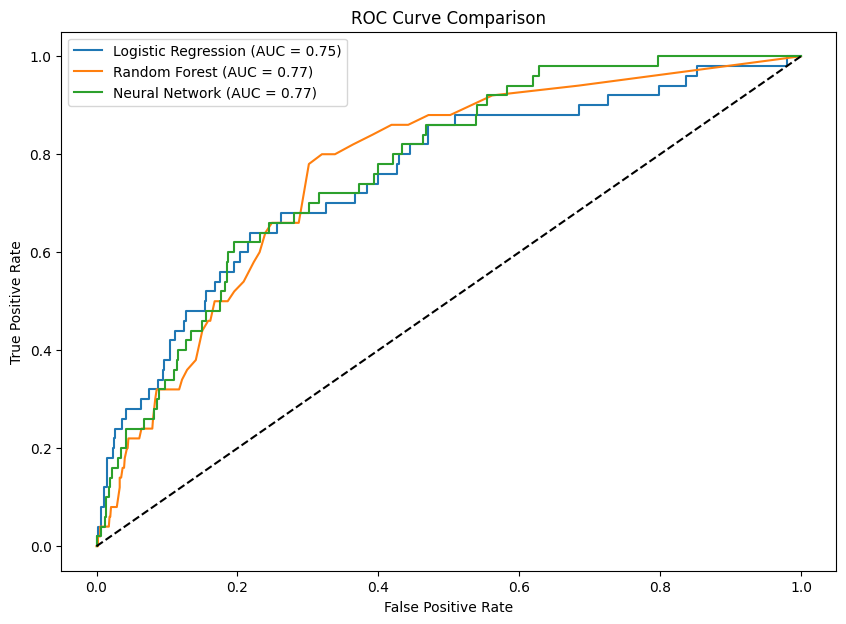

In [38]:
# --- Prepare data for supervised models ---
df_model = df.copy()

# Encode categorical variables
df_model = pd.get_dummies(df_model, columns=['gender', 'work_type', 'Residence_type', 'smoking_status'], drop_first=True)
df_model['ever_married'] = df_model['ever_married'].map({'Yes': 1, 'No': 0})

# Separate features (X) and target (y)
X = df_model.drop('stroke', axis=1)
y = df_model['stroke']

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED, stratify=y)

# --- Handle class imbalance using SMOTE on the training set ---
smote = SMOTE(random_state=SEED)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# --- Scale the data ---
scaler = StandardScaler()
X_train_resampled_scaled = scaler.fit_transform(X_train_resampled)
X_test_scaled = scaler.transform(X_test)

# --- Train and Evaluate Models ---

# 1. Logistic Regression
lr_model = LogisticRegression(random_state=SEED, max_iter=1000)
lr_model.fit(X_train_resampled_scaled, y_train_resampled)
y_pred_lr = lr_model.predict(X_test_scaled)
print("\n--- Logistic Regression Results ---")
print(classification_report(y_test, y_pred_lr))

# 2. Random Forest
rf_model = RandomForestClassifier(random_state=SEED)
rf_model.fit(X_train_resampled_scaled, y_train_resampled)
y_pred_rf = rf_model.predict(X_test_scaled)
print("\n--- Random Forest Results ---")
print(classification_report(y_test, y_pred_rf))

# 3. Feedforward Neural Network
nn_model = Sequential([
    Dense(128, input_dim=X_train_resampled_scaled.shape[1], activation='relu'),
    Dropout(0.1),
    Dense(32, activation='relu'),
    Dropout(0.1),
    Dense(1, activation='sigmoid')
])
nn_model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
early_stop = EarlyStopping(patience=5, restore_best_weights=True, monitor='val_loss')

nn_model.fit(X_train_resampled_scaled, y_train_resampled,
             validation_data=(X_test_scaled, y_test),
             epochs=25, batch_size=50, callbacks=[early_stop], verbose=0)

# Using the optimal threshold you found
y_pred_nn_prob = nn_model.predict(X_test_scaled)
y_pred_nn = (y_pred_nn_prob > 0.36).astype(int)
print("\n--- Neural Network Results ---")
print(classification_report(y_test, y_pred_nn))

# --- Performance Comparison (ROC Curve) ---
y_prob_lr = lr_model.predict_proba(X_test_scaled)[:, 1]
y_prob_rf = rf_model.predict_proba(X_test_scaled)[:, 1]
y_prob_nn = nn_model.predict(X_test_scaled).ravel()

fpr_lr, tpr_lr, _ = roc_curve(y_test, y_prob_lr)
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_prob_rf)
fpr_nn, tpr_nn, _ = roc_curve(y_test, y_prob_nn)

plt.figure(figsize=(10, 7))
plt.plot(fpr_lr, tpr_lr, label=f"Logistic Regression (AUC = {auc(fpr_lr, tpr_lr):.2f})")
plt.plot(fpr_rf, tpr_rf, label=f"Random Forest (AUC = {auc(fpr_rf, tpr_rf):.2f})")
plt.plot(fpr_nn, tpr_nn, label=f"Neural Network (AUC = {auc(fpr_nn, tpr_nn):.2f})")
plt.plot([0, 1], [0, 1], 'k--') # Dashed baseline
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend()
plt.show()
